In [1]:
display(HTML("<style>.container { width:100% !important; }</style>"))

HTML{String}("<style>.container { width:100% !important; }</style>")

#### MIT license (c) 2019 by Andrew Lyasoff

#### Jupyter notebook written in Julia 1.1.0. It implements on a CPUs the numerical program for computing the exercise boundary and the price of an American-style call option described in Sec. 18.4 of "Stochastic Methods in Asset Pricing" (pp. 514-516). The same program is implemented in Python in Appendix B.3 of SMAP.

Note the formula $\int_a^bf(t)dt={1\over2}(b-a)\int_{-1}^{+1}f\bigl({1\over2}(b-a)s+{1\over2}(a+b)\bigr)d s$ to use with FastGaussQuadratures.

In [1]:
## the number of grid points over the time domain is set below
## 5000 is excessive and is meant to test Julia's capabilities
total_grid_no=5000 #this number must be divisible by pnmb

5000

Introduce the parameters in the model.

In [2]:
KK=40.0; # strike
sigma=0.3; # volatility
delta=0.07; # dividend
rr=0.02; # interest
TT=0.5; # time to maturity
DLT=TT/(total_grid_no) # distance between two grid points in the time domain
ABSC=range(0.0,length=total_grid_no+1,stop=TT) # the entire grid on the time domain
VAL=[max(KK,KK*(rr/delta)) for x in ABSC]; # first guess for the exercise boundary

In [3]:
using SpecialFunctions
using Interpolations
using Roots
using FastGaussQuadrature
nodes,weights=gausslegendre( 200 );

function EUcall(S::Float64,t::Float64,K::Float64,σ::Float64,r::Float64,δ::Float64)
        local v1,v2
        v1=(δ-r+σ^2/2.0)*t+log(K/S)
        v2=(-δ + r + σ^2/2.0)*t - log(K/S)
        v3=σ*sqrt(2.0*t)
        return -K*(exp(-t*r)/2)+K*(exp(-t*r)/2)*erf(v1/v3)+S*(exp(-t*δ)/2)*erf(v2/v3)+S*(exp(-t*δ)/2)
    end;

function F(ϵ::Int64,t::Float64,u::Float64,v::Float64,r::Float64,δ::Float64,σ::Float64)
        v1=(r-δ+ϵ*σ^2/2)*(u-t)-log(v)
        v2=σ*sqrt(2*(u-t))
        return 1.0+erf(v1/v2)
    end;

function ah(t::Float64,z::Float64,r::Float64,δ::Float64,σ::Float64,f)
        return (exp(-δ*(z-t))*(δ/2)*F(1,t,z,f(z)/f(t),r,δ,σ))
    end;

function bh(t::Float64,z::Float64,r::Float64,δ::Float64,σ::Float64,K::Float64,f)
        return (exp(-r*(z-t))*(r*K/2)*F(-1,t,z,f(z)/f(t),r,δ,σ))
    end;

function make_grid0(step::Float64,size::Int64)
        return 0.0:step:(step+(size-1)*step)
    end;

In [4]:
function mainF(start_iter::Int64,nmb_of_iter::Int64,conv_tol::Float64,K::Float64,σ::Float64,δ::Float64,r::Float64,T::Float64,Δ::Float64,nmb_grd_pnts::Int64,vls::Array{Float64,1},nds::Array{Float64,1},wghts::Array{Float64,1})
    local no_iter,conv_check,absc,absc0,valPrev,val,loc,f
    absc=range(0.0,length=nmb_grd_pnts+1,stop=T)
    absc0=range(0.0,length=nmb_grd_pnts,stop=(T-Δ));
    val=vls;
    f=CubicSplineInterpolation(absc,val,extrapolation_bc = Interpolations.Line())
    no_iter=start_iter;
    conv_check=100.0
    while no_iter<nmb_of_iter&&conv_check>conv_tol
        no_iter+=1
        loc=[max(K,K*(r/δ))]
        for ttt=Iterators.reverse(absc0)
            an=[(1/2)*(T-ttt)*ah(ttt,(1/2)*(T-ttt)*s+(1/2)*(ttt+T),r,δ,σ,f) for s in nodes]
            bn=[(1/2)*(T-ttt)*bh(ttt,(1/2)*(T-ttt)*s+(1/2)*(ttt+T),r,δ,σ,K,f) for s in nodes]
            aaa=weights'*an
            bbb=weights'*bn;
            LRT=find_zero(x->x-K-EUcall(x,T-ttt,K,σ,r,δ)-aaa*x+bbb,(K-10,K+20));
            pushfirst!(loc,LRT)
        end
        valPrev=val
        val=loc
        f=CubicSplineInterpolation(absc,val,extrapolation_bc = Interpolations.Line())
        conv_check=maximum(abs.(valPrev-val))
    end
    return absc,val,conv_check,no_iter
end

mainF (generic function with 1 method)

Run the main routine. The third argument is an upper bound on the total iterations to run. 
The last two arguments control FastGaussQuadrature.

masterF(prnmb,start_iter,nmb_of_iter,conv_tol,K,σ,δ,r,T,Δ,no_grd_pnts,vls,nds,wghts)


mainF(start_iter, nmb_of_iter, conv_tol, $K$, $\sigma$, $\delta$, $r$, $T$, $\Delta$, no_grd_pnts, vls, nds, wghts)

In [5]:
@time ABSC,VAL,conv,iterations=mainF(0,100,1.0e-5,KK,sigma,delta,rr,TT,DLT,total_grid_no,VAL,nodes,weights);

 13.992447 seconds (406.23 M allocations: 6.942 GiB, 3.71% gc time)


The call to 'masterF' can be repeated with the most recent VAL and the second argument set to the number of already performed iterations.

In [6]:
conv,iterations

(9.63110706209136e-6, 23)

In [7]:
f=CubicSplineInterpolation(ABSC,VAL,extrapolation_bc = Interpolations.Line());

In [8]:
using Plots
pyplot()

Plots.PyPlotBackend()

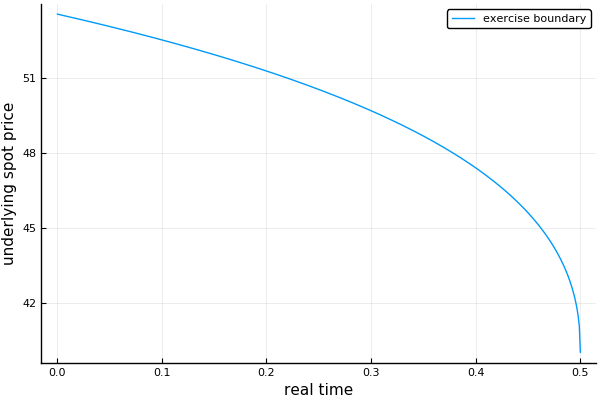

In [9]:
plotgrid=ABSC[1]:.001:ABSC[end];
pval=[f(x) for x in plotgrid];
plot(plotgrid,pval,label="exercise boundary")
xlabel!("real time")
ylabel!("underlying spot price")

In [11]:
f(0)

53.58270125587188

The price of the EU call option at the money ($S_0=K$) with $T={1\over2}$:

In [12]:
EUcall(KK,TT,KK,sigma,rr,delta)

2.8378265020118754

The early exercise premium for at the money option at $t=0$ is:

In [13]:
an=[(0.5*(TT-0.0))*exp(-delta*((1/2)*(TT-0.0)*s+(1/2)*(0.0+TT)-0.0))*(KK*delta/2)*F(1,0.0,(1/2)*(TT-0.0)*s+(1/2)*(0.0+TT),f((1/2)*(TT-0.0)*s+(1/2)*(0.0+TT))/KK,rr,delta,sigma) for s in nodes]
bn=[(0.5*(TT-0.0))*exp(-rr*((1/2)*(TT-0.0)*s+(1/2)*(0.0+TT)-0.0))*(rr*KK/2)*F(-1,0.0,(1/2)*(TT-0.0)*s+(1/2)*(0.0+TT),f((1/2)*(TT-0.0)*s+(1/2)*(0.0+TT))/KK,rr,delta,sigma)  for s in nodes]
aaa=weights'*an
bbb=weights'*bn;
EEP=aaa-bbb
EEP

0.10081943488743587

The price of an American at the money call with 6 months to expiry is:

In [14]:
EUcall(KK,TT,KK,sigma,rr,delta)+EEP

2.938645936899311